In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from pprint import pprint

In [2]:
# data = [
#     {
#         "Id": 0,
#         "ArrivalTime": "2016-05-01T06:36:00",
#         "LeaveTime": "2016-05-01T13:28:00"
#     }, {
#         "Id": 1,
#         "ArrivalTime": "2016-05-01T14:17:00",
#         "LeaveTime": "2016-05-02T01:35:00"
#     }, {
#         "Id": 2,
#         "ArrivalTime": "2016-05-04T00:15:00",
#         "LeaveTime": "2016-05-04T06:55:00"
#     }, {
#         "Id": 3,
#         "ArrivalTime": "2016-05-04T06:54:00",
#         "LeaveTime": "2016-05-04T07:20:00"
#     }, {
#         "Id": 4,
#         "ArrivalTime": "2016-05-04T06:30:00",
#         "LeaveTime": "2016-05-04T07:40:00"
#     }
# ]

with open('../data/parking_data.json') as f:
    data = json.load(f)

pprint(data[:10])

[{'ArrivalTime': '2016-05-01T06:36:00',
  'Id': 0,
  'LeaveTime': '2016-05-01T13:28:00'},
 {'ArrivalTime': '2016-05-01T14:17:00',
  'Id': 1,
  'LeaveTime': '2016-05-02T01:35:00'},
 {'ArrivalTime': '2016-05-04T00:15:00',
  'Id': 2,
  'LeaveTime': '2016-05-04T06:55:00'},
 {'ArrivalTime': '2016-05-04T06:54:00',
  'Id': 3,
  'LeaveTime': '2016-05-04T07:20:00'},
 {'ArrivalTime': '2016-05-04T06:30:00',
  'Id': 4,
  'LeaveTime': '2016-05-04T07:40:00'}]


### Approach overview
So main idea here is to transform all dates into 1 coordinate system - timestamps. After that generate `big vector` of zeros (from arrival_time of first auto to leave_time of last auto in json), where each element represents one timestamp. So this method is based on assumption that the most recent date is stored in last auto's `LeaveTime` json field. If no - then additional method like `find_latest_timestamp_in_json`should be implemented. So, in worst scenario (where there is a car, which stayed 1 year at parking lot) this solution will occupy:

sizeof(int32) \* 365days \* 24hours \* 60mins \* 60sec ~ 126 Mb of RAM.
also we need to add size of json in RAM (I haven't included reading from file by chunks), and tmp vector, which also will ocupy 126 Mb in worst scenario. So, 252 mb will be occupied for 1 year interval and 1 year car on it.
Solution doesn't care about number of cars in json file (except for memory occupied by this file itself)

After that, iteratively sum each new arrival-leave interval with appropriate interval in `big vector`. After that, some functionality should merge neighbour values into one interval.

In [3]:
from datetime import datetime

minutes_slots_per_day = dict()

time_format = '%Y-%m-%dT%H:%M:%S'

start_time = datetime.strptime(data[0]['ArrivalTime'], time_format)
end_time = datetime.strptime(data[-1]['LeaveTime'], time_format)

total_interval_len = int(end_time.timestamp() - start_time.timestamp()) # returns difference in seconds
total_interval = np.zeros(total_interval_len, dtype=np.int32)

for curr_car_info in data:
    arrival_time = datetime.strptime(curr_car_info['ArrivalTime'], time_format)
    leave_time = datetime.strptime(curr_car_info['LeaveTime'], time_format)
    
    idx_from, idx_to = int(arrival_time.timestamp() - start_time.timestamp()), \
                       int(leave_time.timestamp()   - start_time.timestamp())
    
#     print ('idx_from: {}, idx_to: {}'.format(idx_from, idx_to))
    total_interval[idx_from:idx_to] = total_interval[idx_from:idx_to] + np.ones(idx_to - idx_from)

In [4]:
total_interval.shape[0], total_interval.sum(), total_interval.min(), total_interval.max()

(263040, 95160, 0, 3)

In [5]:
max_indices = np.argwhere(total_interval == np.amax(total_interval))
max_indices = max_indices.flatten().tolist()

In [6]:
def merge_neighbor_to_interval(max_indices):
    # So I can perform merging in several ways. First and the easiest one - is to iterate one by one through
    # the entire list of maximums and compare current one with previous. 
    # Another way to do this, is to use recursion somehow, to achieve log(n) complexity, 
    # but the basic assumption is that max intervals are usually small, and there are few of them
    # and recursion will show the same performance as brute-force algorithm 
    interval_start = max_indices[0]
    last_value_from_interval = max_indices[0]
    intervals_list = list()
    for curr_value in max_indices[1:]:
        if curr_value - last_value_from_interval > 1:
            intervals_list.append([interval_start, last_value_from_interval])
            interval_start = curr_value
            last_value_from_interval = curr_value
        else:
            last_value_from_interval = curr_value
    intervals_list.append([interval_start, last_value_from_interval])
    return intervals_list

indises = [1, 3, 4, 5, 7, 8, 10, 15, 16, 17, 18, 150]

# Check this procedure on some simple list
print(merge_neighbor_to_interval(indises))
print(merge_neighbor_to_interval([1,2,3,4,5]))

[[1, 1], [3, 5], [7, 8], [10, 10], [15, 18], [150, 150]]
[[1, 5]]


In [7]:
result_intervals = merge_neighbor_to_interval(max_indices)
result_intervals[:5]

[[260280, 260339]]

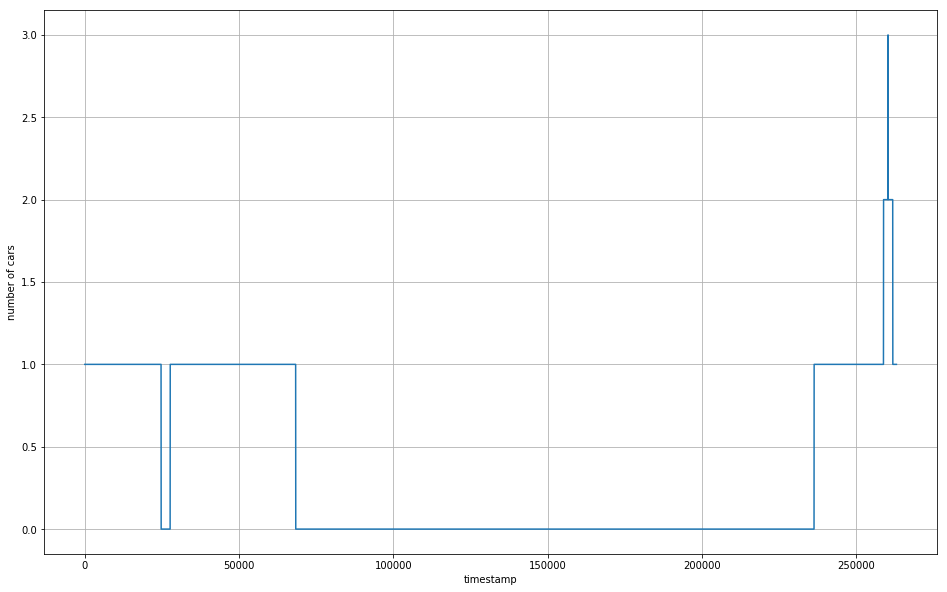

In [8]:
plt.figure(figsize=(16, 10))
plt.xlabel('timestamp')
plt.ylabel('number of cars')
plt.plot(total_interval)
plt.grid(True)
plt.show()

In [9]:
# Get final results

print('Maximum intervals number: {}'.format(len(result_intervals)))
for interval in result_intervals:
    # Interval is in timestamp format, in first_car coordinates (where 0 is timestamp of first car arrival time)
    from_date = datetime.fromtimestamp(interval[0] + start_time.timestamp()).strftime('%Y-%m-%d %H:%M:%S')
    to_date   = datetime.fromtimestamp(interval[1] + start_time.timestamp() + 1).strftime('%Y-%m-%d %H:%M:%S')
    print('There were {} car(s) on parking lot from {} to {}'.format(total_interval[interval[0]],
                                                                   from_date, 
                                                                   to_date))

Maximum intervals number: 1
There were 3 car(s) on parking lot from 2016-05-04 06:54:00 to 2016-05-04 06:55:00
